<a href="https://colab.research.google.com/github/UnitForDataScience/Projects-Fall-2024/blob/main/ConsumerVoice/ConsumerVoice_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wordcloud

In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Import external libraries
!pip install xgboost lightgbm --quiet
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set random seed for reproducibility
RANDOM_STATE = 42

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load CSV file
file_path = '/content/drive/MyDrive/Projects /Projects-Fall-2024/ConsumerVoice/complaints.csv'
df = pd.read_csv(file_path)
df= df.sample(frac=0.01, random_state=42)  # using only 5 percent of data because of high computation

In [4]:
df["Product"].value_counts()

,count
Product,
Credit Reporting,12317
Debt Collection,2739
Loans,2302
Credit Card Services,1683
Bank Accounts and Services,1597


In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

,0
Unnamed: 0,0
product_5,0
narrative,0
Product,0
Date received,0
Sub-product,521
Issue,0
Sub-issue,2344
Company,0
State,59


In [14]:
df["narrative"].iloc[20000]

'On XX/XX/XXXX, I disputed multiple fraudulent charges from a merchant called XXXX. Someone had used my digital card number and I had to get a new one. There were multiple charges {$130.00}, {$550.00}, {$840.00}, {$1100.00}. The only charges that got approved were {$550.00} and {$1100.00}. Apple Card Goldman Sachs refused to credit my account for the {$840.00} and {$130.00} despite them being the same charges from the same day and merchant. I appealed the decisions and on XX/XX/XXXX I was told that the merchant already gave me a credit and that I authorized one of the charges. This is not true. On XX/XX/XXXX, I have message evidence to prove I requested the evidence documentation. As of XX/XX/XXXX, they never provided me with the merchant documentation. They are making claims without providing any proof of them. They are charging me for fraudulent charges even though I didnt authorize them and I have provided evidence that it was not authorized.'

## Text Preprocessing  

In [15]:
import re
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

# Regular Expressions for text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')  # Keep lowercase letters, digits, and some special characters
STOPWORDS = set(stopwords.words('english'))

# function to clean text
def clean_text(text):
    """
    text: a string
    return: cleaned and preprocessed string
    """
    text = str(text).lower()  # Convert text to lowercase
    text = REPLACE_BY_SPACE_RE.sub(' ', text)  # Replace certain symbols with a space
    text = BAD_SYMBOLS_RE.sub('', text)  # Remove unwanted symbols
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)  # Remove stopwords
    return text


df['cleaned_narrative'] = df['narrative'].apply(clean_text)

# verify cleaning process
print(df[['narrative', 'cleaned_narrative']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                 narrative  \
1984274  My loan was transferred from United Shore Fina...   
1290713  In roughly XXXX of 2015 my mother and I regist...   
1677224  What is this complaint about? \n\nMissing Cred...   
1295319  There are multiple inquiries on my Credit Repo...   
637375   ALL REPORTED DATA MUST BE COMPLETE, CORRECT, A...   

                                         cleaned_narrative  
1984274  loan transferred united shore financial servic...  
1290713  roughly xxxx 2015 mother registered company ha...  
1677224  complaint missing credit card information loan...  
1295319         multiple inquiries credit report recognize  
637375   reported data must complete correct proven cha...  


## Text Vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# fit and transform cleaned narratives
X_tfidf = tfidf.fit_transform(df['cleaned_narrative'])

# Check shape of transformed data
print(X_tfidf.shape)

(20638, 5000)


In [18]:
y = df['product_5']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Check shapes of resulting sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16510, 5000) (4128, 5000) (16510,) (4128,)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8640988372093024
Classification Report:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.80      0.85      0.83       312
      Credit Card Services       0.79      0.64      0.71       356
          Credit Reporting       0.89      0.95      0.92      2488
           Debt Collection       0.79      0.64      0.71       528
                     Loans       0.85      0.82      0.84       444

                  accuracy                           0.86      4128
                 macro avg       0.83      0.78      0.80      4128
              weighted avg       0.86      0.86      0.86      4128

Confusion Matrix:
 [[ 264   20   15    7    6]
 [  41  229   68   10    8]
 [   6   22 2369   63   28]
 [   5   14  148  339   22]
 [  12    6   52    8  366]]


Training Logistic Regression...
Logistic Regression Accuracy: 0.8641
Classification Report for Logistic Regression:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.80      0.85      0.83       312
      Credit Card Services       0.79      0.64      0.71       356
          Credit Reporting       0.89      0.95      0.92      2488
           Debt Collection       0.79      0.64      0.71       528
                     Loans       0.85      0.82      0.84       444

                  accuracy                           0.86      4128
                 macro avg       0.83      0.78      0.80      4128
              weighted avg       0.86      0.86      0.86      4128



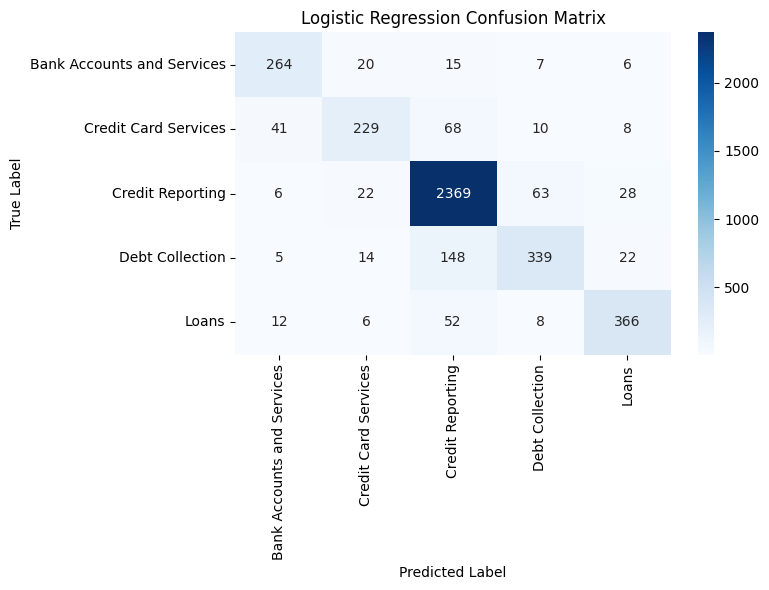


------------------------------------------------------------

Training Multinomial Naive Bayes...
Multinomial Naive Bayes Accuracy: 0.8367
Classification Report for Multinomial Naive Bayes:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.76      0.87      0.81       312
      Credit Card Services       0.71      0.56      0.62       356
          Credit Reporting       0.91      0.91      0.91      2488
           Debt Collection       0.74      0.63      0.68       528
                     Loans       0.72      0.88      0.79       444

                  accuracy                           0.84      4128
                 macro avg       0.77      0.77      0.76      4128
              weighted avg       0.84      0.84      0.83      4128



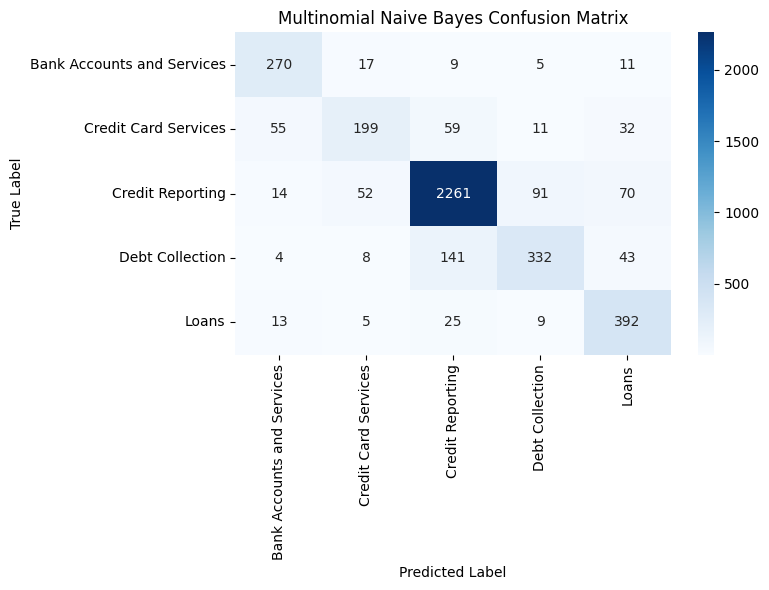


------------------------------------------------------------

Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.7750
Classification Report for K-Nearest Neighbors:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.69      0.69      0.69       312
      Credit Card Services       0.63      0.49      0.55       356
          Credit Reporting       0.79      0.96      0.87      2488
           Debt Collection       0.77      0.35      0.48       528
                     Loans       0.82      0.53      0.65       444

                  accuracy                           0.77      4128
                 macro avg       0.74      0.60      0.65      4128
              weighted avg       0.77      0.77      0.75      4128



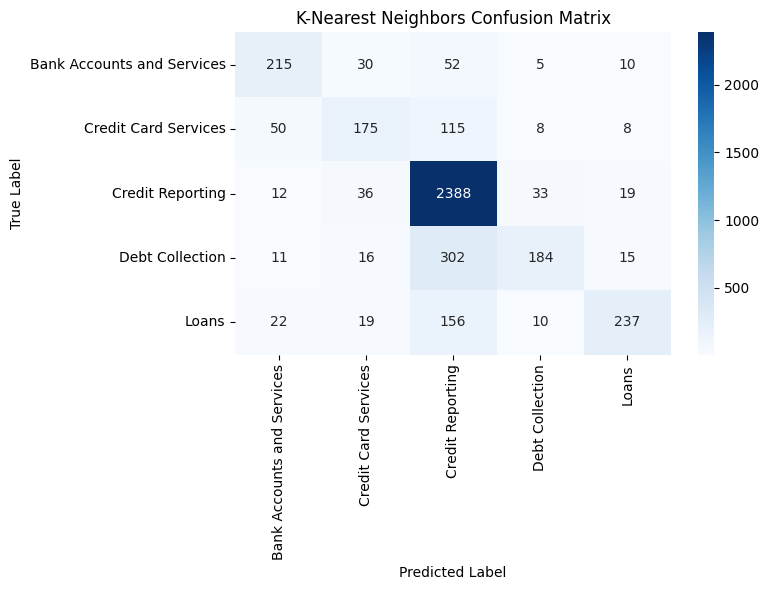


------------------------------------------------------------

Training Decision Tree...
Decision Tree Accuracy: 0.7694
Classification Report for Decision Tree:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.66      0.69      0.67       312
      Credit Card Services       0.58      0.56      0.57       356
          Credit Reporting       0.87      0.87      0.87      2488
           Debt Collection       0.58      0.57      0.57       528
                     Loans       0.68      0.68      0.68       444

                  accuracy                           0.77      4128
                 macro avg       0.67      0.67      0.67      4128
              weighted avg       0.77      0.77      0.77      4128



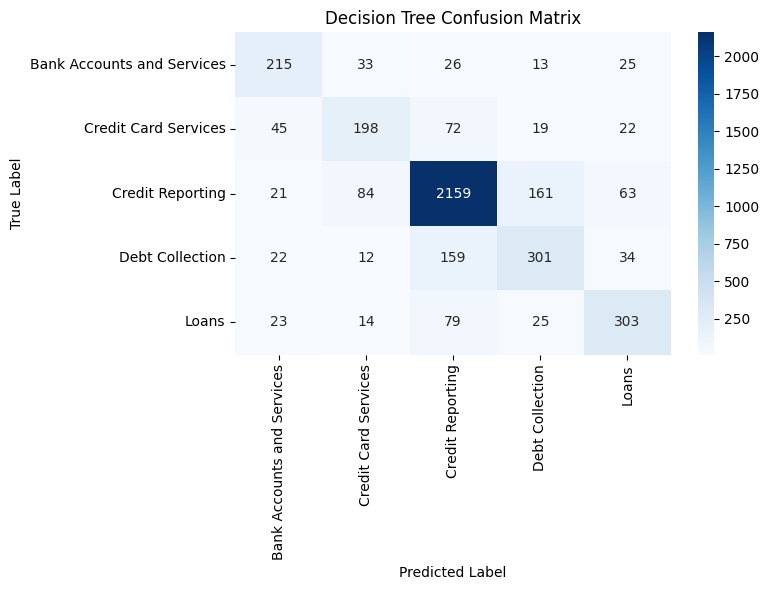


------------------------------------------------------------

Training Random Forest...
Random Forest Accuracy: 0.8508
Classification Report for Random Forest:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.78      0.82      0.80       312
      Credit Card Services       0.83      0.58      0.69       356
          Credit Reporting       0.86      0.97      0.91      2488
           Debt Collection       0.84      0.57      0.68       528
                     Loans       0.84      0.76      0.80       444

                  accuracy                           0.85      4128
                 macro avg       0.83      0.74      0.78      4128
              weighted avg       0.85      0.85      0.84      4128



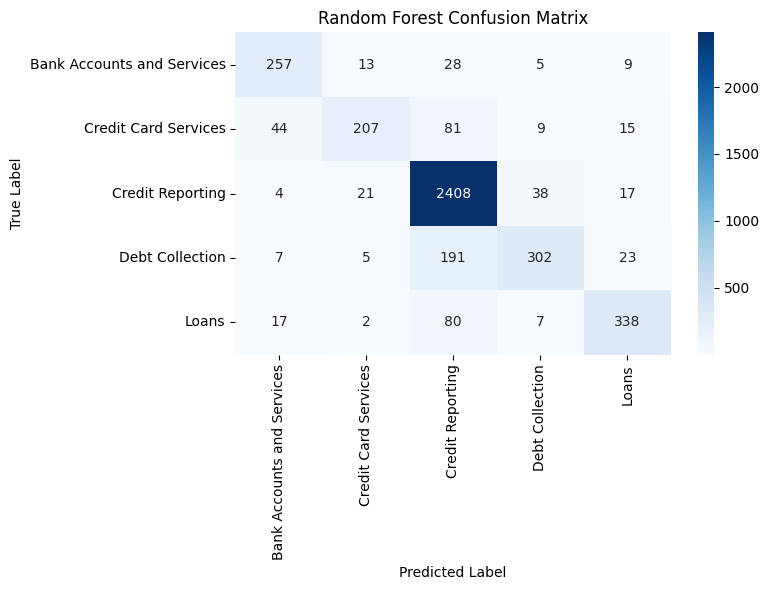


------------------------------------------------------------

Training Extra Trees...
Extra Trees Accuracy: 0.8500
Classification Report for Extra Trees:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.79      0.83      0.81       312
      Credit Card Services       0.81      0.57      0.67       356
          Credit Reporting       0.87      0.96      0.91      2488
           Debt Collection       0.84      0.57      0.68       528
                     Loans       0.83      0.79      0.81       444

                  accuracy                           0.85      4128
                 macro avg       0.83      0.74      0.77      4128
              weighted avg       0.85      0.85      0.84      4128



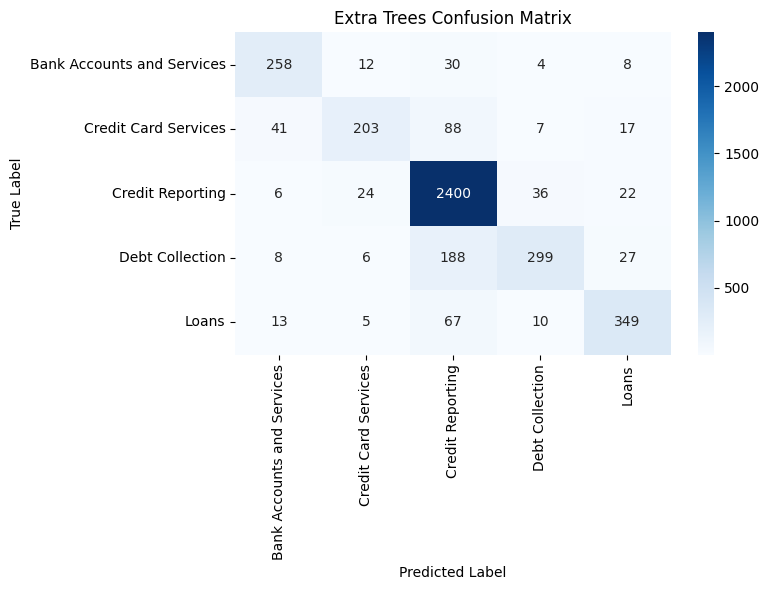


------------------------------------------------------------

Training AdaBoost...
AdaBoost Accuracy: 0.8021
Classification Report for AdaBoost:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.70      0.77      0.73       312
      Credit Card Services       0.66      0.51      0.57       356
          Credit Reporting       0.86      0.91      0.88      2488
           Debt Collection       0.69      0.57      0.63       528
                     Loans       0.75      0.75      0.75       444

                  accuracy                           0.80      4128
                 macro avg       0.73      0.70      0.71      4128
              weighted avg       0.80      0.80      0.80      4128



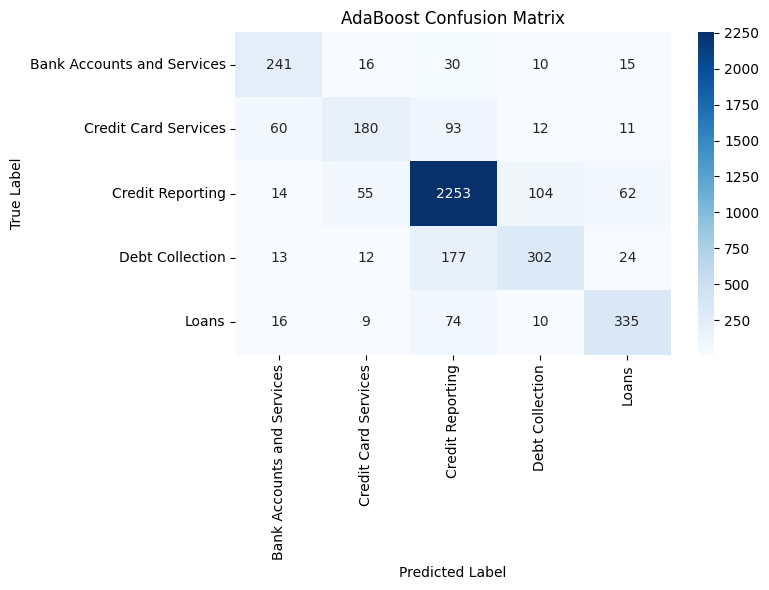


------------------------------------------------------------

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.8542
Classification Report for Gradient Boosting:

                            precision    recall  f1-score   support

Bank Accounts and Services       0.82      0.79      0.80       312
      Credit Card Services       0.77      0.66      0.71       356
          Credit Reporting       0.88      0.95      0.91      2488
           Debt Collection       0.80      0.63      0.70       528
                     Loans       0.85      0.77      0.81       444

                  accuracy                           0.85      4128
                 macro avg       0.82      0.76      0.79      4128
              weighted avg       0.85      0.85      0.85      4128



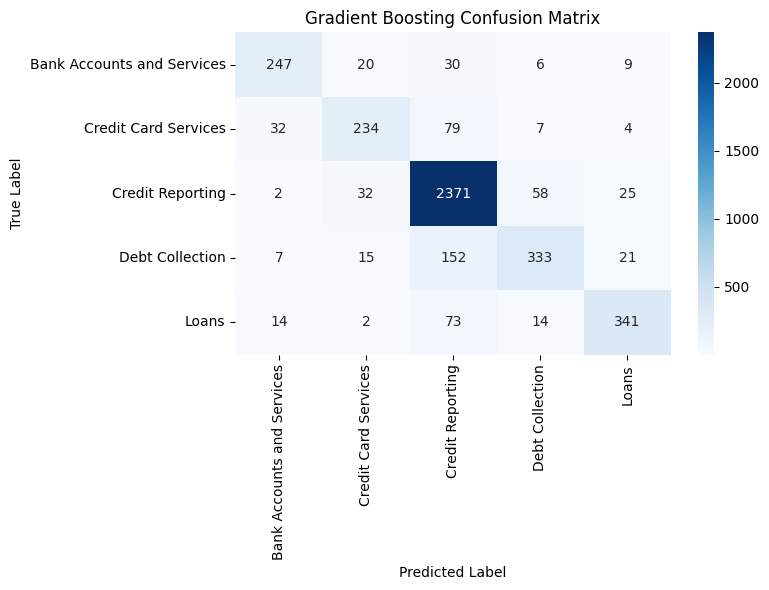


------------------------------------------------------------

Training XGBoost...


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got ['Bank Accounts and Services' 'Credit Card Services' 'Credit Reporting'
 'Debt Collection' 'Loans']

In [23]:
# Define a dictionary of classifiers (excluding Gaussian Naive Bayes, QDA, and MLP)
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Multinomial Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE),
    "Linear SVM": LinearSVC(random_state=RANDOM_STATE),
    "RBF SVM": SVC(kernel='rbf', random_state=RANDOM_STATE)
}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Iterate through classifiers
for name, clf in classifiers.items():
    print(f"Training {name}...")

    # Train and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    # Classification report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=clf.classes_, title=f"{name} Confusion Matrix")

    print("\n" + "-"*60 + "\n")

### Check sample text

In [25]:
# New text input
new_text = ["In January 2024, I entered into a contract with XXXX rental agency to rent a vehicle for a business trip. I used my debit card to secure the rental, and a pre-authorization hold of $500.00 was placed on my account. This hold was supposed to cover any potential damages or additional fees that might arise during the rental period"]

# Step 1: Preprocess the new text
def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = str(text).lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

cleaned_text = [clean_text(text) for text in new_text]

#Transform the text using the same TF-IDF vectorizer
X_new = tfidf.transform(cleaned_text)

#Predict using one of models above: Logistic Regression
predicted_label = classifiers["Logistic Regression"].predict(X_new)

# Output predicted label
print(f"Predicted Label: {predicted_label[0]}")


Predicted Label: Bank Accounts and Services


## Model Optimization